In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.ops import nearest_points, unary_union, linemerge, snap, polygonize
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, GeometryCollection

In [2]:
PLACE = "Budapest, Hungary"

Residential poligonok (úttal érintett, városhatáron belülre vágva): 141


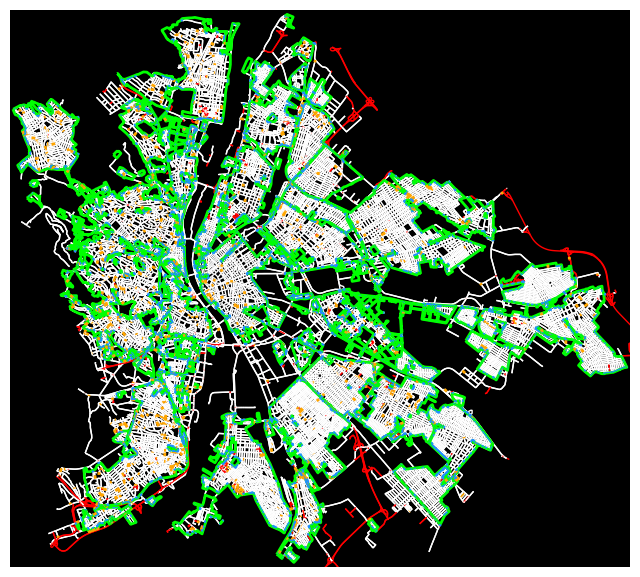

In [3]:
# -----------------------
# PARAMÉTEREK
# -----------------------

MAX_EXT = 200.0    # m: narancs hosszabbítás max
EPS = 0.25         # m: saját node környéke (narancs metszésnél)
DIST_LIM = 100.0   # m: ha node ennyire van a lakó-határtól, húzzuk rá kékkel
MIN_SEG = 0.1      # m: minimális szakaszhossz

# -----------------------
# PLACE (példa) – nálad már létezik
# -----------------------
# PLACE = "Budapest, Hungary"

# -----------------------
# 1) ÚTHÁLÓZAT
# -----------------------
G = ox.graph_from_place(PLACE, network_type="drive")
Gp = ox.project_graph(G)  # méteres CRS
nodes, edges = ox.graph_to_gdfs(Gp, nodes=True, edges=True)

# dead-end node-ok (undirected degree=1)
deg = dict(Gp.to_undirected().degree())
dead = nodes.loc[[n for n, d in deg.items() if d == 1]].copy()

# -----------------------
# segédek (narancshoz)
# -----------------------
def _pts(geom):
    if geom.is_empty:
        return []
    t = geom.geom_type
    if t == "Point":
        return [geom]
    if t == "MultiPoint":
        return list(geom.geoms)
    if t == "LineString":
        return [Point(geom.coords[0]), Point(geom.coords[-1])]
    if t in ("MultiLineString", "GeometryCollection"):
        out = []
        for g in geom.geoms:
            out += _pts(g)
        return out
    return []

def _ray_from_deadend(node_id):
    pt = nodes.loc[node_id].geometry

    # JAVÍTÁS: MultiDiGraph-nál edges() alapból a kimenő éleket adja.
    # Dead-end lehet olyan node is, ahol csak bejövő él van (one-way), ilyenkor edges() üres.
    elist = list(Gp.edges(node_id, keys=True, data=True))
    if not elist:
        elist = list(Gp.in_edges(node_id, keys=True, data=True))
    if not elist:
        return None, None

    u, v, k, data = elist[0]
    geom = data.get("geometry")

    if geom is None:
        other = v if u == node_id else u
        geom = LineString([pt, nodes.loc[other].geometry])

    c = list(geom.coords)
    if len(c) < 2:
        return None, None

    a0, a1 = Point(c[0]), Point(c[-1])
    if pt.distance(a0) <= pt.distance(a1):
        a, b = c[0], c[1]
    else:
        a, b = c[-1], c[-2]

    dx, dy = (a[0] - b[0], a[1] - b[1])  # kifelé
    n = (dx * dx + dy * dy) ** 0.5
    if n == 0:
        return None, None

    far = Point(pt.x + dx / n * MAX_EXT, pt.y + dy / n * MAX_EXT)
    return pt, LineString([pt, far])

# -----------------------
# 2) NARANCS: dead-end -> következő utca
# -----------------------
sidx_edges = edges.sindex
orange = []

for node_id in dead.index:
    pt, ray = _ray_from_deadend(node_id)
    if ray is None:
        continue

    cand = edges.iloc[list(sidx_edges.intersection(ray.bounds))]

    best_p, best_s = None, np.inf
    for (eu, ev, ek), row in cand.iterrows():
        if node_id in (eu, ev):  # saját él ne
            continue
        inter = ray.intersection(row.geometry)
        for p in _pts(inter):
            s = ray.project(p)  # távolság a ray mentén
            if s <= EPS or s >= best_s:
                continue
            best_s, best_p = s, p

    if best_p is not None:
        seg = LineString([pt, best_p])
        if seg.length > MIN_SEG:
            orange.append(seg)

orange = gpd.GeoSeries(orange, crs=nodes.crs)

# -----------------------
# 3) LAKOTT TERÜLET POLYGONOK + BOUNDARY (MINDEN releváns folt)
# -----------------------
res = ox.features_from_place(PLACE, tags={"landuse": "residential"})
res = res[res.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
if res.empty:
    raise RuntimeError("Nincs landuse=residential poligon ehhez a PLACE-hez az OSM-ben.")

res_p = res.to_crs(nodes.crs)

# -----------------------
# 3.1) hivatalos városhatárra vágás
# -----------------------
def _safe_make_valid(g):
    if g is None or g.is_empty:
        return g
    try:
        from shapely import make_valid
        return make_valid(g)
    except Exception:
        try:
            return g.buffer(0)
        except Exception:
            return g

place_gdf = ox.geocode_to_gdf(PLACE)
if place_gdf.empty:
    raise RuntimeError("Nem tudtam lekérni a PLACE hivatalos határát (geocode_to_gdf üres).")

city_geom = _safe_make_valid(place_gdf.geometry.iloc[0])
if city_geom is None or city_geom.is_empty:
    raise RuntimeError("A lekért városhatár geometria üres/hibás.")

city_boundary = gpd.GeoSeries([city_geom], crs=place_gdf.crs).to_crs(nodes.crs).iloc[0]
city_boundary = _safe_make_valid(city_boundary)
if city_boundary is None or city_boundary.is_empty:
    raise RuntimeError("A városhatár projekció után üres/hibás lett.")

cut_geoms = []
for g in res_p.geometry:
    g = _safe_make_valid(g)
    if g is None or g.is_empty:
        continue
    inter = g.intersection(city_boundary)
    if inter is None or inter.is_empty:
        continue
    inter = _safe_make_valid(inter)
    if inter is None or inter.is_empty:
        continue
    if inter.geom_type in ("Polygon", "MultiPolygon"):
        cut_geoms.append(inter)

if not cut_geoms:
    raise RuntimeError("A városhatáron belül nem maradt residential poligon.")

res_p = gpd.GeoDataFrame(geometry=cut_geoms, crs=nodes.crs)

# úthálózat (projektált) összefésülve 1 geometriába
roads_union = edges.geometry.union_all()

# residential komponensek szétszedése (MultiPolygon -> külön Polygonok)
polys = []
for g in res_p.geometry:
    if g.geom_type == "Polygon":
        polys.append(g)
    elif g.geom_type == "MultiPolygon":
        polys.extend(list(g.geoms))

if not polys:
    raise RuntimeError("A residential geometriákból nem tudtam poligonokat kinyerni.")

# kiválasztás: csak azok, ahol az úthálózat ténylegesen BELÉP (vonalhossz > 0)
keep_polys = []
for p in polys:
    inter = roads_union.intersection(p)
    score = getattr(inter, "length", 0.0)
    if np.isfinite(score) and score > 0:
        keep_polys.append(p)

if not keep_polys:
    c = roads_union.centroid
    keep_polys = [p for p in polys if p.contains(c)]
    if not keep_polys:
        raise RuntimeError("Nem találtam olyan residential poligont, amihez az úthálózat tartozna.")

# egyesített (MultiPolygon) a kékhez + boundary a plothoz
res_area = unary_union(keep_polys)          # Polygon/MultiPolygon
boundary = res_area.boundary               # LineString/MultiLineString
boundary_gs = gpd.GeoSeries([boundary], crs=nodes.crs)

# opcionális: külön poligonok is, ha később kell
res_polys_gdf = gpd.GeoDataFrame(geometry=keep_polys, crs=nodes.crs)

print("Residential poligonok (úttal érintett, városhatáron belülre vágva):", len(keep_polys))

# -----------------------
# 4) KÉK: minden node (DIST_LIM-en belül) -> lakóhatár
# -----------------------
blue = []
for node_id, row in nodes.iterrows():
    pt = row.geometry
    d = pt.distance(boundary)
    if np.isfinite(d) and d <= DIST_LIM:
        _, near = nearest_points(pt, boundary)
        if near is not None and (not near.is_empty):
            seg = LineString([pt, near])
            if seg.length > MIN_SEG:
                blue.append(seg)

blue = gpd.GeoSeries(blue, crs=nodes.crs)

# -----------------------
# 5) PLOT (WGS84)
# -----------------------
import matplotlib.pyplot as plt

boundary_wgs = boundary_gs.to_crs(4326)
orange_wgs = orange.to_crs(4326) if len(orange) else gpd.GeoSeries([], crs=nodes.crs).to_crs(4326)
blue_wgs = blue.to_crs(4326) if len(blue) else gpd.GeoSeries([], crs=nodes.crs).to_crs(4326)

def has_name(val):
    if isinstance(val, list):
        return any(isinstance(i, str) and i.strip() for i in val)
    if pd.isna(val):
        return False
    return isinstance(val, str) and val.strip()

edge_colors = [
    "white" if has_name(data.get("name")) else "red"
    for _, _, _, data in G.edges(keys=True, data=True)
]

fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_color=edge_colors,
    bgcolor="black",
    show=False,
    close=False
)

ax.set_aspect("auto")

boundary_wgs.plot(ax=ax, color="lime", linewidth=2)

if len(orange_wgs):
    orange_wgs.plot(ax=ax, color="orange", linewidth=2.0)

if len(blue_wgs):
    blue_wgs.plot(ax=ax, color="dodgerblue", linewidth=1.8)

minx, miny, maxx, maxy = boundary_wgs.total_bounds
pad = 0.002
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

plt.show()


Összes vonal: 74099
Hiba a unary_union / linemerge során: NameError("name 'MultiLineString' is not defined")
Végső hálózat: all_lines_proj (nem sikerült az egyesítés)
geom_type:
 LineString         74098
MultiLineString        1
Name: count, dtype: int64
total_bounds: [ 344332.34789609 5246571.31384412  374450.56665333 5274849.16432872]


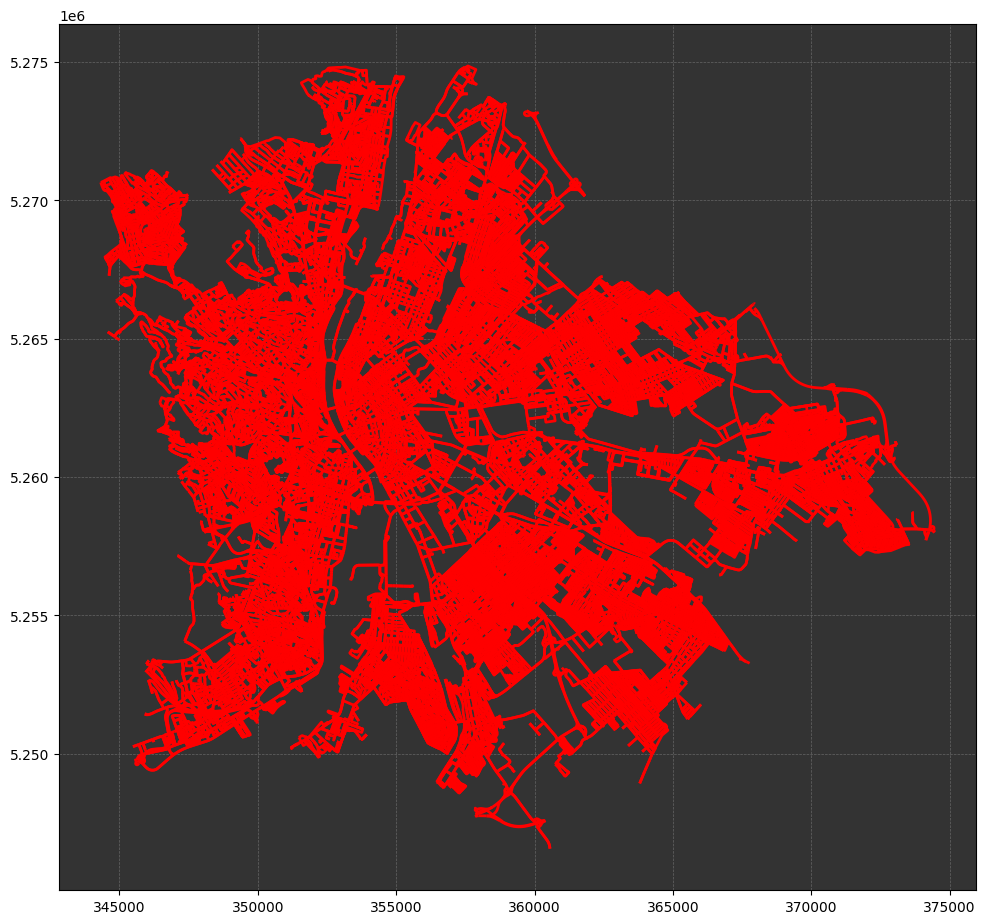

In [4]:
# Feltételezzük, hogy az előző cellából ezek léteznek:
# edges (GeoDataFrame, projektált CRS-ben)
# boundary_gs (GeoSeries, projektált CRS-ben)  -- vagy boundary (shapely)
# orange (GeoSeries, projektált CRS-ben)
# blue (GeoSeries, projektált CRS-ben)

# --- kompatibilitás: ha boundary_gs nincs, de boundary igen ---
if "boundary_gs" not in globals():
    if "boundary" in globals():
        boundary_gs = gpd.GeoSeries([boundary], crs=edges.crs)
    else:
        raise RuntimeError("Nincs boundary_gs és boundary sem a notebookban.")

# 1) Vonalak összegyűjtése
street_lines    = [g for g in edges.geometry if g is not None and not g.is_empty]
boundary_lines  = [g for g in boundary_gs.geometry if g is not None and not g.is_empty]

connector_lines = []
if "orange" in globals() and orange is not None and len(orange):
    connector_lines += [g for g in orange.geometry if g is not None and not g.is_empty]
if "blue" in globals() and blue is not None and len(blue):
    connector_lines += [g for g in blue.geometry if g is not None and not g.is_empty]

all_lines_proj = street_lines + boundary_lines + connector_lines
print("Összes vonal:", len(all_lines_proj))

if not all_lines_proj:
    raise RuntimeError("Nincs egyesíthető vonal (all_lines_proj üres).")

def extract_lines(geom):
    """Kiszed minden LineString-et / MultiLineString-et egy tetszőleges geometriából."""
    if geom is None or geom.is_empty:
        return []
    if isinstance(geom, LineString):
        return [geom]
    if isinstance(geom, MultiLineString):
        return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out = []
        for g in geom.geoms:
            out.extend(extract_lines(g))
        return out
    return []

# 2) Topológiai egyesítés (ha sikerül)
try:
    union_geom  = unary_union(all_lines_proj)
    union_lines = extract_lines(union_geom)
    print("unary_union után vonalak:", len(union_lines))

    if union_lines:
        merged_geom  = linemerge(union_lines)
        merged_lines = extract_lines(merged_geom)
        print("linemerge után vonalak:", len(merged_lines))
    else:
        merged_lines = []
except Exception as e:
    print("Hiba a unary_union / linemerge során:", repr(e))
    union_lines  = []
    merged_lines = []

# 3) Végső hálózat kiválasztása
if merged_lines:
    final_lines = merged_lines
    print("Végső hálózat: merged_lines")
elif union_lines:
    final_lines = union_lines
    print("Végső hálózat: union_lines")
else:
    final_lines = all_lines_proj
    print("Végső hálózat: all_lines_proj (nem sikerült az egyesítés)")

network_gs_proj = gpd.GeoSeries(final_lines, crs=edges.crs)
print("geom_type:\n", network_gs_proj.geom_type.value_counts())
print("total_bounds:", network_gs_proj.total_bounds)

# 4) Plot – CSAK az egyesített / kiválasztott vonalhálózat
fig, ax = plt.subplots(figsize=(10, 10))

network_gs_proj.plot(ax=ax, linewidth=2.0, color="red")
ax.set_aspect("equal")
ax.set_facecolor("0.2")
ax.grid(True, color="0.4", linestyle="--", linewidth=0.5)

minx, miny, maxx, maxy = network_gs_proj.total_bounds
side = max(maxx - minx, maxy - miny)
pad  = side * 0.05
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

plt.tight_layout()
plt.show()

Levágott (utcák+narancs+kék) vonalak: 66433
Boundary elemek: 1
Végső geom_type:
 LineString    52611
Name: count, dtype: int64


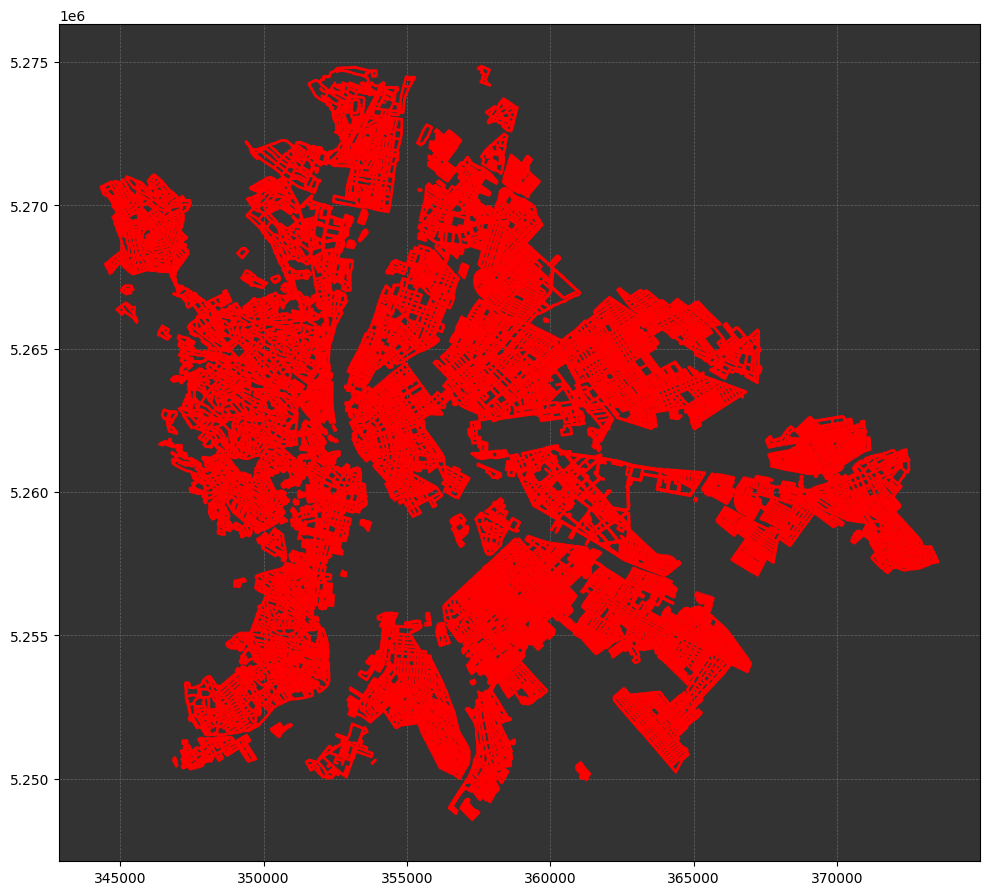

In [5]:
# Kell:
# edges (GeoDataFrame, projektált CRS)
# orange (GeoSeries, projektált CRS) - opcionális
# blue (GeoSeries, projektált CRS)   - opcionális
#
# és az előző cellából valamelyik:
#  - res_area (Polygon/MultiPolygon)  <-- EZ A LEGJOBB
#  - vagy res_polys_gdf (GeoDataFrame a keep_polys-szal)
#  - vagy boundary_gs + keep_polys (ha így nevezted)

# --- boundary GeoSeries biztosítása ---
if "boundary_gs" not in globals():
    if "boundary" in globals():
        boundary_gs = gpd.GeoSeries([boundary], crs=edges.crs)
    else:
        raise RuntimeError("Nincs boundary_gs és boundary sem a notebookban.")

# --- CLIP POLY: az ÖSSZES releváns lakott terület uniója ---
if "res_area" in globals() and res_area is not None:
    clip_poly = res_area
elif "res_polys_gdf" in globals() and res_polys_gdf is not None and len(res_polys_gdf):
    clip_poly = unary_union(res_polys_gdf.geometry)
elif "keep_polys" in globals() and keep_polys is not None and len(keep_polys):
    clip_poly = unary_union(keep_polys)
else:
    raise RuntimeError(
        "Nem találok 'res_area'-t / 'res_polys_gdf'-et / 'keep_polys'-t. "
        "Előbb futtasd azt a cellát, ami az összes releváns residential poligont előállítja."
    )

def extract_lines(geom):
    if geom is None or geom.is_empty:
        return []
    gt = geom.geom_type
    if gt == "LineString":
        return [geom]
    if gt == "MultiLineString":
        return list(geom.geoms)
    if gt == "GeometryCollection":
        out = []
        for g in geom.geoms:
            out.extend(extract_lines(g))
        return out
    return []

def clip_lines(lines, poly):
    out = []
    for ln in lines:
        if ln is None or ln.is_empty:
            continue
        cut = ln.intersection(poly)
        out.extend(extract_lines(cut))
    return [g for g in out if g is not None and not g.is_empty]

# 1) vágandó rétegek összegyűjtése (boundary NEM vágandó)
street_lines = [g for g in edges.geometry if g is not None and not g.is_empty]

orange_lines = []
if "orange" in globals() and orange is not None and len(orange):
    orange_lines = [g for g in orange.geometry if g is not None and not g.is_empty]

blue_lines = []
if "blue" in globals() and blue is not None and len(blue):
    blue_lines = [g for g in blue.geometry if g is not None and not g.is_empty]

# 2) levágás az ÖSSZES releváns lakott területre: utcák + narancs + kék
clipped_other = clip_lines(street_lines + orange_lines + blue_lines, clip_poly)
print("Levágott (utcák+narancs+kék) vonalak:", len(clipped_other))

# 3) boundary hozzáadása (változatlanul)
boundary_lines = [g for g in boundary_gs.geometry if g is not None and not g.is_empty]
print("Boundary elemek:", len(boundary_lines))

# 4) VÉGSŐ EGYRÉTEGŰ HÁLÓ: union + linemerge
all_final = clipped_other + boundary_lines
if not all_final:
    raise RuntimeError("Nincs semmi a végső hálóhoz (all_final üres).")

try:
    u = unary_union(all_final)
    u_lines = extract_lines(u)
    merged_geom = linemerge(u_lines) if u_lines else u
    final_lines = extract_lines(merged_geom) or u_lines or all_final
except Exception as e:
    print("Union/merge hiba:", repr(e))
    final_lines = all_final

network_gs_proj = gpd.GeoSeries(final_lines, crs=edges.crs)
print("Végső geom_type:\n", network_gs_proj.geom_type.value_counts())

# 5) Plot: egyetlen vonalréteg, egy szín
fig, ax = plt.subplots(figsize=(10, 10))
network_gs_proj.plot(ax=ax, linewidth=2.0, color="red")

ax.set_aspect("equal")
ax.set_facecolor("0.2")
ax.grid(True, color="0.4", linestyle="--", linewidth=0.5)

# zoom az ÖSSZES lakott terület uniójára
minx, miny, maxx, maxy = clip_poly.bounds
side = max(maxx - minx, maxy - miny)
pad  = side * 0.05
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

plt.tight_layout()
plt.show()

Levágott (utcák+narancs+kék) vonalak: 66433
Boundary elemek: 347
DO_SNAP_STRIP = True
Connectorok száma: 17564
clipped_other (snap/strip után): 77604
Végső geom_type:
 LineString    60615
Name: count, dtype: int64


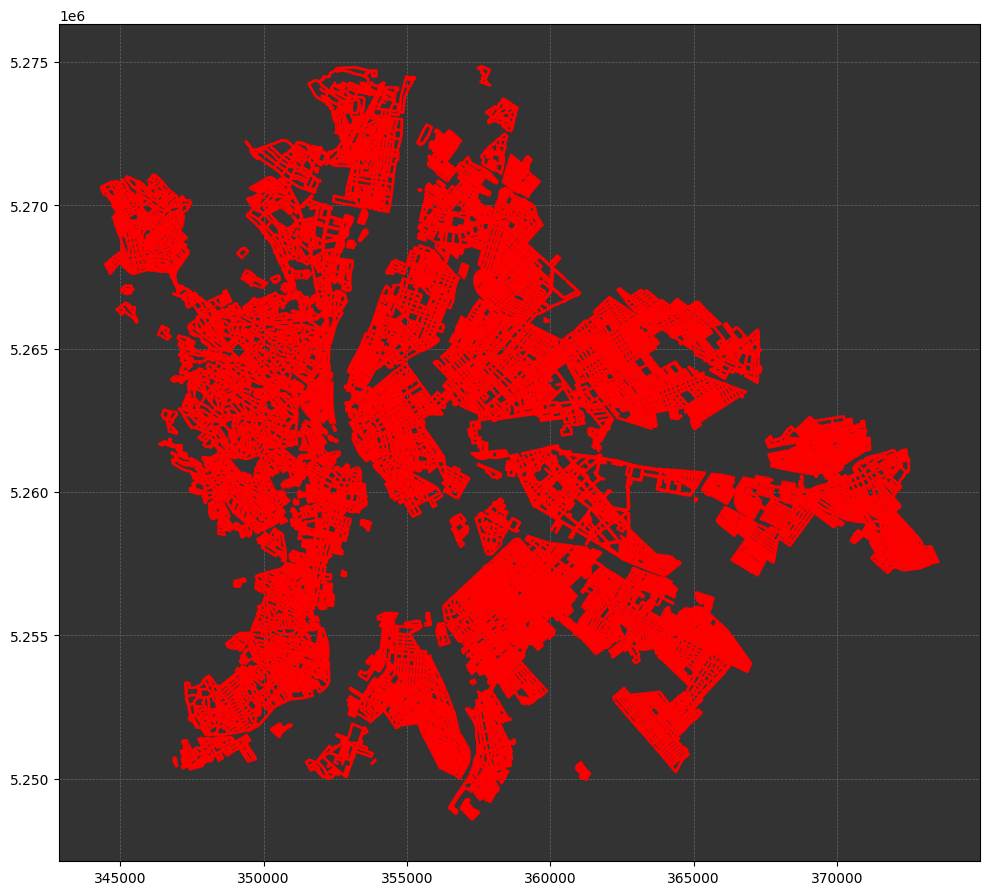

In [6]:
# -------------------------------------------------
# PARAMÉTEREK
# -------------------------------------------------
DO_SNAP_STRIP = True   # <<< ha nem kell a boundary menti "dupla fal" kezelés, állítsd False-ra

# SNAP_TOL (méter)
# -----------------------------------------------
# A hálózat csomópontjait és vonalvégeit ennyire "ráhúzza"
# a lakott terület határvonalára (boundary).
#
# Mire jó:
# - Ha az utca szinte érinti a boundary-t, de nem pontosan,
#   akkor ezzel ténylegesen rákötjük.
#
# Tünet -> mit állíts:
# - Ha az utcák nem csatlakoznak a boundary-hez: NÖVELD (pl. 5–8 m)
# - Ha túl sok pont "elcsúszik": CSÖKKENTSD (pl. 1–2 m)

SNAP_TOL = 3.0


# STRIP_TOL (méter)
# -----------------------------------------------
# A boundary körül ekkora szélességű sávot kivágunk
# a belső úthálózatból, hogy eltüntessük a párhuzamos
# "dupla fal" vonalakat.
#
# Mire jó:
# - Ha a boundary mellett fut egy másik, szinte fedésben lévő utca,
#   akkor azt eltünteti.
#
# Tünet -> mit állíts:
# - Ha még mindig van dupla vonal: NÖVELD (pl. 3–4 m)
# - Ha eltűnnek fontos utcák: CSÖKKENTSD (pl. 1–1.5 m)

STRIP_TOL = 10.0


# JOIN_TOL (méter)
# -----------------------------------------------
# Ha egy vonalvégpont ennyire közel van a boundary-hez,
# akkor EXPLICIT összekötő szegmenst rajzolunk közéjük.
#
# Mire jó:
# - Biztosítja, hogy a hálózat ténylegesen kapcsolódjon
#   a boundary-hez, ne csak "majdnem".
#
# Tünet -> mit állíts:
# - Ha maradnak rések a poligon zárásánál: NÖVELD (pl. 8–12 m)
# - Ha felesleges, hosszú rákötések jelennek meg: CSÖKKENTSD (pl. 4–5 m)

JOIN_TOL = 12.0


# DEDUP_EPS (méter)
# -----------------------------------------------
# Az egymáshoz nagyon közeli végpontokat egynek vesszük,
# hogy ne rajzoljon több szinte azonos összekötő vonalat.
#
# Mire jó:
# - Megakadályozza a "tüskés" határvonalat.
#
# Tünet -> mit állíts:
# - Ha sok egymás melletti kis összekötés van: NÖVELD (0.5–1.0)
# - Ha fontos pontok elvesznek: CSÖKKENTSD (0.1–0.2)

DEDUP_EPS = 1.0


# -------------------------------------------------
# BEMENETEK (előző cellákból)
# edges (GeoDataFrame, projektált CRS)
# orange (GeoSeries) - opcionális
# blue   (GeoSeries) - opcionális
#
# és EGYIK ezek közül:
#  - res_area (Polygon/MultiPolygon)  <-- ajánlott (összes releváns lakott folt uniója)
#  - res_polys_gdf / keep_polys (ebből union-t csinálunk)
#  - boundary_gs + best_poly (régi, de ez az eset NEM jó több foltra)
# -------------------------------------------------

def extract_lines(geom):
    if geom is None or geom.is_empty:
        return []
    gt = geom.geom_type
    if gt == "LineString":
        return [geom]
    if gt == "MultiLineString":
        return list(geom.geoms)
    if gt == "GeometryCollection":
        out = []
        for g in geom.geoms:
            out.extend(extract_lines(g))
        return out
    return []

def clip_lines(lines, poly):
    out = []
    for ln in lines:
        if ln is None or ln.is_empty:
            continue
        cut = ln.intersection(poly)
        out.extend(extract_lines(cut))
    return [g for g in out if g is not None and not g.is_empty]

def endpoints_of_lines(lines):
    pts = []
    for ln in lines:
        if ln is None or ln.is_empty:
            continue
        c = list(ln.coords)
        if len(c) >= 2:
            pts.append(Point(c[0]))
            pts.append(Point(c[-1]))
    return pts

def dedup_points(points, eps):
    kept = []
    for p in points:
        ok = True
        for q in kept:
            if p.distance(q) <= eps:
                ok = False
                break
        if ok:
            kept.append(p)
    return kept

# -------------------------------------------------
# 0) CLIP POLY (MINDEN folt!)
# -------------------------------------------------
if "res_area" in globals() and res_area is not None:
    clip_poly = res_area
elif "res_polys_gdf" in globals() and res_polys_gdf is not None and len(res_polys_gdf):
    clip_poly = unary_union(res_polys_gdf.geometry)
elif "keep_polys" in globals() and keep_polys is not None and len(keep_polys):
    clip_poly = unary_union(keep_polys)
else:
    raise RuntimeError(
        "Nem találok 'res_area'-t / 'res_polys_gdf'-et / 'keep_polys'-t. "
        "Előbb futtasd azt a cellát, ami az összes releváns residential poligont előállítja."
    )

# boundary-t a clip_poly-ból számoljuk (egységes, minden foltra)
boundary_line = clip_poly.boundary
boundary_lines = extract_lines(boundary_line)
if not boundary_lines:
    raise RuntimeError("Nem tudtam boundary vonalakat kinyerni (boundary_lines üres).")

# -------------------------------------------------
# 1) Összegyűjtés: vágandó rétegek (boundary-t NEM vágjuk)
# -------------------------------------------------
street_lines = [g for g in edges.geometry if g is not None and not g.is_empty]

orange_lines = []
if "orange" in globals() and orange is not None and len(orange):
    orange_lines = [g for g in orange.geometry if g is not None and not g.is_empty]

blue_lines = []
if "blue" in globals() and blue is not None and len(blue):
    blue_lines = [g for g in blue.geometry if g is not None and not g.is_empty]

# -------------------------------------------------
# 2) Levágás MINDEN lakott foltra: utcák + narancs + kék
# -------------------------------------------------
clipped_other = clip_lines(street_lines + orange_lines + blue_lines, clip_poly)
print("Levágott (utcák+narancs+kék) vonalak:", len(clipped_other))
print("Boundary elemek:", len(boundary_lines))

# -------------------------------------------------
# 3) (Opcionális) boundary melletti dupla-fal kezelés
# -------------------------------------------------
connectors = []

if DO_SNAP_STRIP and clipped_other:
    other_union = unary_union(clipped_other)
    if other_union and (not other_union.is_empty):

        # SNAP
        other_snapped = snap(other_union, boundary_line, SNAP_TOL)
        snapped_lines = extract_lines(other_snapped)

        # strip-ben futó részek végpontjai -> boundary-re ráhúzó connectorok
        border_strip = boundary_line.buffer(STRIP_TOL)

        in_strip = []
        for ln in snapped_lines:
            in_strip.extend(extract_lines(ln.intersection(border_strip)))

        strip_endpoints = dedup_points(endpoints_of_lines(in_strip), DEDUP_EPS)

        for p in strip_endpoints:
            d = p.distance(boundary_line)
            if np.isfinite(d) and (1e-9 < d <= JOIN_TOL):
                _, q = nearest_points(p, boundary_line)
                if q is not None and (not q.is_empty):
                    seg = LineString([p, q])
                    if seg.length > 1e-6:
                        connectors.append(seg)

        # dupla fal eltüntetés: vágjuk ki a strip-et a snapped hálóból
        other_clean = other_snapped.difference(border_strip)
        clipped_other = [g for g in extract_lines(other_clean) if g is not None and not g.is_empty]

print("DO_SNAP_STRIP =", DO_SNAP_STRIP)
print("Connectorok száma:", len(connectors))
print("clipped_other (snap/strip után):", len(clipped_other))

# -------------------------------------------------
# 4) Végső EGY réteg: (clipped_other + connectors + boundary) -> union + linemerge
# -------------------------------------------------
all_final = clipped_other + connectors + boundary_lines
if not all_final:
    raise RuntimeError("Nincs semmi a végső hálóhoz (all_final üres).")

try:
    u = unary_union(all_final)  # noding is itt történik
    u_lines = extract_lines(u)
    merged_geom = linemerge(u_lines) if u_lines else u
    final_lines = extract_lines(merged_geom) or u_lines or all_final
except Exception as e:
    print("Union/merge hiba:", repr(e))
    final_lines = all_final

network_gs_proj = gpd.GeoSeries(final_lines, crs=edges.crs)
print("Végső geom_type:\n", network_gs_proj.geom_type.value_counts())

# -------------------------------------------------
# 5) Plot: egyetlen vonalréteg
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
network_gs_proj.plot(ax=ax, linewidth=2.0, color="red")

ax.set_aspect("equal")
ax.set_facecolor("0.2")
ax.grid(True, color="0.4", linestyle="--", linewidth=0.5)

# zoom az ÖSSZES lakott foltra
minx, miny, maxx, maxy = clip_poly.bounds
side = max(maxx - minx, maxy - miny)
pad  = side * 0.05
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

plt.tight_layout()
plt.show()

Vonalak száma a hálózatban: 60615
union_geom típusa: <class 'shapely.geometry.multilinestring.MultiLineString'>
Keletkezett poligonok száma: 18085


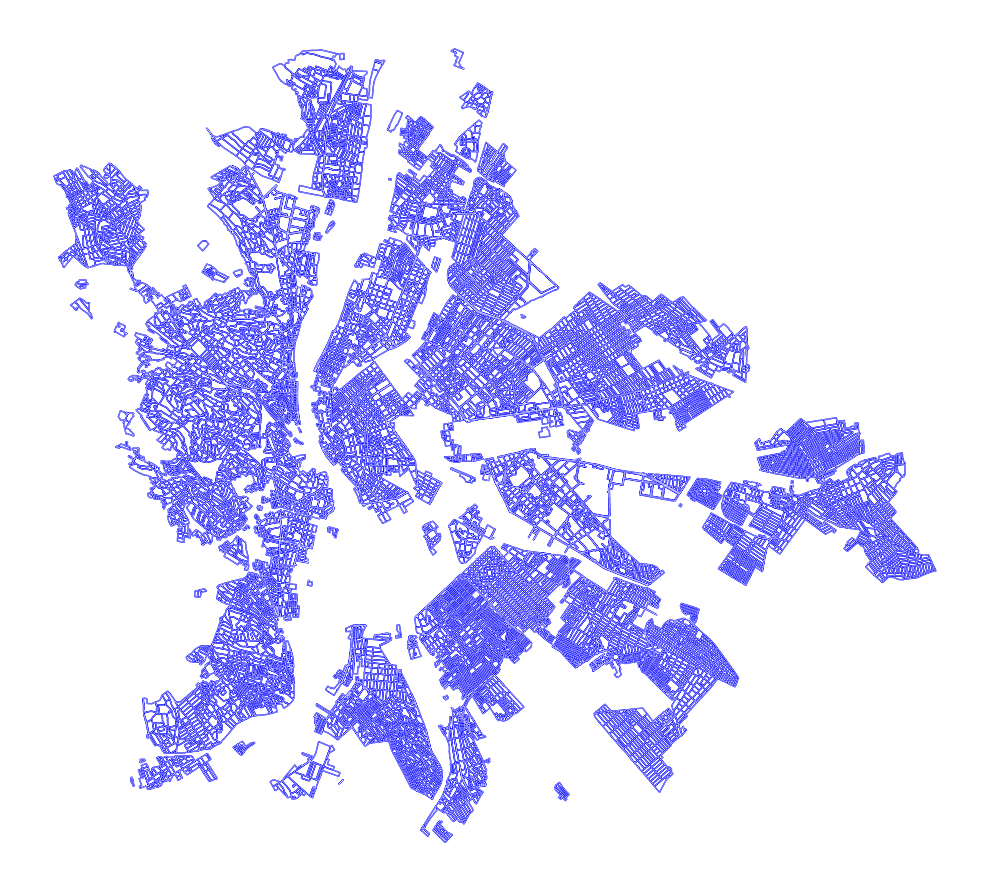

polygons_gdf készen van – egy sor = egy zárt terület (cell / blokk).


In [7]:
# ------------------------------------------------------------------
# 0) BEMENET: network_gs_proj
#    (egyesített, érintkező vonalhálózat PROJEKTÁLT CRS-ben)
# ------------------------------------------------------------------

if "network_gs_proj" not in globals():
    raise RuntimeError("network_gs_proj nem létezik – előbb futtasd a hálózatépítő cellát.")

print("Vonalak száma a hálózatban:", len(network_gs_proj))

# Csak érvényes LineString-ek
lines = [
    g for g in network_gs_proj.geometry
    if isinstance(g, LineString) and not g.is_empty
]

if not lines:
    raise RuntimeError("Nincsenek érvényes LineString geometriák a network_gs_proj-ban.")


# ------------------------------------------------------------------
# 1) VONALHÁLÓZAT EGYESÍTÉSE (TOPOLÓGIAI ELŐKÉSZÍTÉS)
# ------------------------------------------------------------------

# Egyetlen topológiailag konzisztens linework
union_geom = unary_union(lines)

print("union_geom típusa:", type(union_geom))


# ------------------------------------------------------------------
# 2) POLIGONIZÁLÁS – zárt cellákból poligonok
# ------------------------------------------------------------------

polygons = list(polygonize(union_geom))

print("Keletkezett poligonok száma:", len(polygons))

polygons_gdf = gpd.GeoDataFrame(
    geometry=polygons,
    crs=network_gs_proj.crs
)

# Opcionális zajszűrés (ha sok apró, értelmetlen cella keletkezik)
# min_area = 1000.0  # m²
# polygons_gdf = polygons_gdf[polygons_gdf.area > min_area]


# ------------------------------------------------------------------
# 3) ELLENŐRZŐ PLOT
# ------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 10))

# Poligonok kontúrja
polygons_gdf.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=1.0
)

# Vonalhálózat háttérként
network_gs_proj.plot(
    ax=ax,
    color="white",
    linewidth=0.3
)

ax.set_aspect("equal")
ax.set_facecolor("black")
ax.set_axis_off()

plt.tight_layout()
plt.show()

print("polygons_gdf készen van – egy sor = egy zárt terület (cell / blokk).")

Polygonok száma (polygonize után): 18085
Min area (m²): 0.0004923876164946717
< MIN_AREA db: 7342
[STOP] Kicsi poligon (13621, area=893.945614) nem talál valódi szomszédot közös éllel.
Merge lépések: 4456
Végső poligonok: 13630
Végső min area (m²): 893.9456140415125
Végső < MIN_AREA db: 2851
Ellenőrzés:
  sum(area) - union(area) (átfedés indikátor): 5.960464477539063e-08
  symmetric_difference area (terület eltérés): 0.0


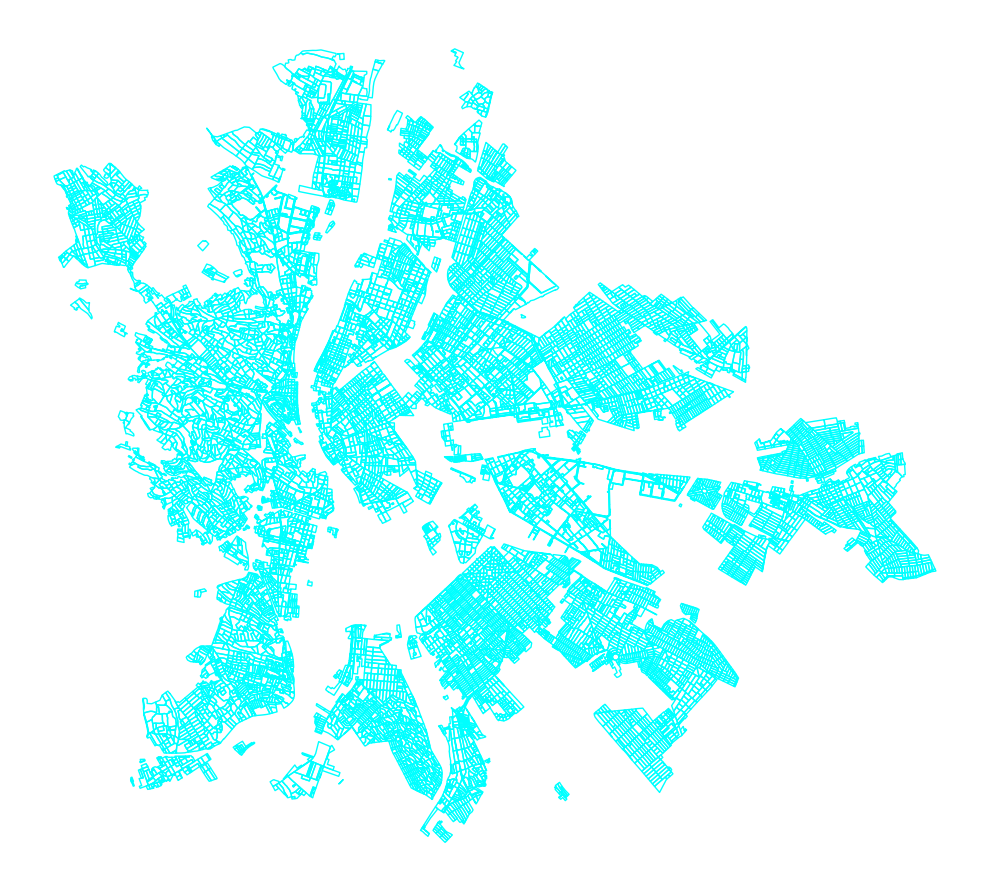

Kész: polygons_merged_gdf – kicsik egyenként beolvasztva a leghosszabb közös élű szomszédba.


In [8]:
# ------------------------------------------------------------
# 0) BEMENET
# ------------------------------------------------------------
if "network_gs_proj" not in globals():
    raise RuntimeError("network_gs_proj nem létezik – előbb futtasd a hálózatépítő cellát.")

# ------------------------------------------------------------
# PARAMÉTEREK
# ------------------------------------------------------------
MIN_AREA = 5000.0      # m²: ez alatt beolvasztjuk
MAX_STEPS = 20000    # biztonsági limit (nagy hálónál se szálljon el)
PLOT_DEBUG = True

# ------------------------------------------------------------
# 1) VONALHÁLÓ -> POLIGONOK
# ------------------------------------------------------------
linework = unary_union([g for g in network_gs_proj.geometry if g is not None and (not g.is_empty)])
polys = list(polygonize(linework))
if not polys:
    raise RuntimeError("polygonize nem adott vissza poligonokat (nincs elég zárt hurok / noding probléma).")

polygons_gdf = gpd.GeoDataFrame(geometry=polys, crs=network_gs_proj.crs).reset_index(drop=True)

# tisztítás (csak minimálisan, hogy ne "torzítsunk")
# buffer(0) itt csak validálásra: nem használunk toleranciás szomszédkeresést!
polygons_gdf["geometry"] = polygons_gdf.geometry.buffer(0)
polygons_gdf = polygons_gdf[polygons_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].reset_index(drop=True)

print("Polygonok száma (polygonize után):", len(polygons_gdf))
print("Min area (m²):", float(polygons_gdf.geometry.area.min()))
print("< MIN_AREA db:", int((polygons_gdf.geometry.area < MIN_AREA).sum()))

# eredeti lefedettség (ellenőrzéshez)
orig_union = unary_union(polygons_gdf.geometry)

# ------------------------------------------------------------
# 2) KICS I POLIGONOK BEOLVASZTÁSA (EGYENKÉNT)
#    - csak VALÓDI szomszéd: közös határhossz > 0
#    - cél: akivel a leghosszabb a közös határ
# ------------------------------------------------------------
pg = polygons_gdf.copy().reset_index(drop=True)

def shared_boundary_length(a, b):
    inter = a.boundary.intersection(b.boundary)
    return getattr(inter, "length", 0.0)

steps = 0
while steps < MAX_STEPS:
    steps += 1

    areas = pg.geometry.area
    small_idx = areas[areas < MIN_AREA].index.tolist()
    if not small_idx:
        break

    # mindig a legkisebbet olvasztjuk be először (stabilabb)
    i = min(small_idx, key=lambda k: areas.iloc[k])
    gi = pg.geometry.iloc[i]

    # szomszédkeresés bbox + valódi közös határ
    sidx = pg.sindex
    cand = list(sidx.intersection(gi.bounds))
    cand = [j for j in cand if j != i]

    best_j = None
    best_len = 0.0

    for j in cand:
        gj = pg.geometry.iloc[j]
        L = shared_boundary_length(gi, gj)
        if L > best_len:
            best_len = L
            best_j = j

    # Ha nincs valódi szomszéd közös éllel, akkor nem tudjuk szabályosan beolvasztani
    # (ez tipikusan azt jelenti, hogy a polygonize partícióban van mikro rés / diszkontinuitás)
    if best_j is None or best_len <= 0:
        print(f"[STOP] Kicsi poligon ({i}, area={areas.iloc[i]:.6f}) nem talál valódi szomszédot közös éllel.")
        break

    # olvasztás: i -> best_j
    new_geom = unary_union([gi, pg.geometry.iloc[best_j]]).buffer(0)

    # frissítés: célpoligon helyére új geom, kicsit eldobjuk
    pg.at[best_j, "geometry"] = new_geom
    pg = pg.drop(index=i).reset_index(drop=True)

print("Merge lépések:", steps)
print("Végső poligonok:", len(pg))
print("Végső min area (m²):", float(pg.geometry.area.min()))
print("Végső < MIN_AREA db:", int((pg.geometry.area < MIN_AREA).sum()))

polygons_merged_gdf = pg  # <- ezt használd tovább

# ------------------------------------------------------------
# 3) KEMÉNY ELLENŐRZÉSEK: nincs átfedés, nincs területvesztés
# ------------------------------------------------------------
final_union = unary_union(polygons_merged_gdf.geometry)

sum_area = float(polygons_merged_gdf.geometry.area.sum())
union_area = float(final_union.area)
overlap_area = sum_area - union_area   # ha > 0, akkor átfedések vannak

symdiff_area = float(orig_union.symmetric_difference(final_union).area)  # ha > 0, akkor vesztés/hozzáadás történt

print("Ellenőrzés:")
print("  sum(area) - union(area) (átfedés indikátor):", overlap_area)
print("  symmetric_difference area (terület eltérés):", symdiff_area)

# ------------------------------------------------------------
# 4) PLOT
# ------------------------------------------------------------
if PLOT_DEBUG:
    fig, ax = plt.subplots(figsize=(10, 10))
    polygons_merged_gdf.plot(ax=ax, facecolor="none", edgecolor="cyan", linewidth=1.0)
    ax.set_aspect("equal")
    ax.set_facecolor("black")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

print("Kész: polygons_merged_gdf – kicsik egyenként beolvasztva a leghosszabb közös élű szomszédba.")

In [9]:
polygons_merged_gdf.to_file('../../adatok/working/bb_szigetek_v2.gpkg', layer='network_polygons', driver='GPKG')